In [22]:
import numpy as np
import pandas as pd
import random
from scipy import stats
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

Read in hand-made specificity manipulation to tidy into a dataframe.

In [2]:
specificity_material = pd.read_excel('specificity_material.xlsx')
consonant_strings = ['xkq', 'qxsw', 'mtpv', 'rjdnw', 'wvcnz', 'zbxlv','tqvgqrz', 'bxfjwts','mghljkqr',
                     'kmlsdjtw','ptrgsbkv','zrtqgfplh','vpbyzkgrf','htbqzylm','ypdcglkc','fxldmr','rvqf']
stimuli = pd.DataFrame([])
stimuli['item_nr'] = range(1, int(len(specificity_material)*3)+1)
stimuli['set_nr'] = np.repeat(range(1, int(len(specificity_material))+1),3)
stimuli['specificity'] = ['low','mid','high'] * len(specificity_material)
random.seed(42)
consonant_strings = random.sample(consonant_strings*44,720)
stimuli['word1'] = [word for triplet in zip(consonant_strings[:360], specificity_material['phrase_word1'], consonant_strings[360:]) for word in triplet]
stimuli['word2'] = [word for triplet in zip(specificity_material['word_lowSpec'], specificity_material['phrase_word2'], specificity_material['word_highSpec']) for word in triplet]
stimuli

,item_nr,set_nr,specificity,word1,word2
0,1,1,low,mghljkqr,alloy
1,2,1,mid,brown,alloy
2,3,1,high,vpbyzkgrf,bronze
3,4,2,low,vpbyzkgrf,amphibian
4,5,2,mid,hopping,amphibian
...,...,...,...,...,...
355,356,119,mid,violent,weather
356,357,119,high,xkq,storm
357,358,120,low,kmlsdjtw,wine
358,359,120,mid,sparkling,wine


Add in psycholinguistic features to the dataframe.

In [3]:
resources = [('zipf','../resources/subtlex_uk.csv','LogFreq(Zipf)'),
             ('CNC_M','../resources/brysbaert_etal_2014.csv','Conc_M'),
             ('CNC_SD','../resources/brysbaert_etal_2014.csv','Conc_SD'),
             ('imageability','../resources/scott_etal_2019.csv','IMAG'),
             ('valence','../resources/scott_etal_2019.csv','VAL'),
             ('AoA','../resources/kuperman_etal_2012.csv','Rating.Mean'),
             ('RT','../resources/blp-items.xls','rt')]

def get_stimulus_property(resource='', dataframe=None):
    stim_property = resource[0]
    resource_fname = resource[1]
    col_name = resource[2]
    if stim_property == 'RT':
        resource_df = pd.read_excel(resource_fname, index_col=0)
    else:
        resource_df = pd.read_csv(resource_fname, index_col=0)
    dataframe = dataframe.merge(resource_df[col_name].rename(stim_property), left_on='word2', right_index=True, how='left')
    dataframe = dataframe.astype({stim_property:'float'})
    return dataframe

# count word length in number of letters
stimuli['length'] = stimuli['word2'].str.len()

for resource in resources:
    stimuli = get_stimulus_property(resource=resource, dataframe=stimuli)

stimuli

C:\Users\rl05\AppData\Local\Temp\ipykernel_6932\4271295112.py:16: DtypeWarning: Columns (11,25) have mixed types. Specify dtype option on import or set low_memory=False.
  resource_df = pd.read_csv(resource_fname, index_col=0)


,item_nr,set_nr,specificity,word1,word2,length,zipf,CNC_M,CNC_SD,imageability,valence,AoA,RT
0,1,1,low,mghljkqr,alloy,5,3.13,4.29,0.98,NaN,NaN,14.53,583.416667
1,2,1,mid,brown,alloy,5,3.13,4.29,0.98,NaN,NaN,14.53,583.416667
2,3,1,high,vpbyzkgrf,bronze,6,4.41,4.47,1.07,6.086,6.000,10.00,543.526316
3,4,2,low,vpbyzkgrf,amphibian,9,2.78,3.77,1.38,6.030,5.412,8.33,NaN
4,5,2,mid,hopping,amphibian,9,2.78,3.77,1.38,6.030,5.412,8.33,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,356,119,mid,violent,weather,7,5.12,3.83,1.34,NaN,NaN,5.94,538.763158
356,357,119,high,xkq,storm,5,4.46,4.70,0.67,6.429,3.543,4.94,505.600000
357,358,120,low,kmlsdjtw,wine,4,4.84,4.79,0.50,6.618,6.229,7.90,523.000000
358,359,120,mid,sparkling,wine,4,4.84,4.79,0.50,6.618,6.229,7.90,523.000000


After testing the script in the scanner, with a long enough inter-trial interval for cortical activations to return to baseline (\~2s), the experiment would be too long (\~1.5hrs effective recording time; longer with setting up and brief breaks between blocks). We decided to reduce the number of trials per condition to 100, yielding 900 trials total (effective recording time \~43 minutes). Below we document how we reduce the number of trials. 

Drop 20 sets of items to keep the total number of sets to 100 (i.e., 100 trials per condition). We do this by calculating the difference between Age of Acquisition ratings of the high and low specificity items in each set, then removing 20 sets with the largest differences.

In [15]:
stimuli_specificity_difference = stimuli[stimuli.specificity != 'low'].copy()
stimuli_copy = stimuli.copy()

feature_differences = pd.DataFrame()
aoa_difference = []
frequency_difference = []
rt_difference = []
for i in stimuli_specificity_difference.set_nr.unique():
    aoa_difference.append(stimuli_specificity_difference.loc[stimuli_specificity_difference.set_nr == i].AoA.diff().abs().tolist()[1])
    frequency_difference.append(stimuli_specificity_difference.loc[stimuli_specificity_difference.set_nr == i].zipf.diff().abs().tolist()[1])
    rt_difference.append(stimuli_specificity_difference.loc[stimuli_specificity_difference.set_nr == i].RT.diff().tolist()[1])
feature_differences['set_nr'] = stimuli_specificity_difference.set_nr.unique().astype(int)
feature_differences['aoa'] = aoa_difference
feature_differences['zipf'] = frequency_difference
feature_differences['rt'] = rt_difference
sets_to_be_removed = feature_differences.sort_values(by='aoa', ascending=False).set_nr.head(20)
print(f'Sets to be removed: (n={len(sets_to_be_removed)})', sets_to_be_removed.tolist())

stimuli = stimuli[~stimuli['set_nr'].isin(sets_to_be_removed)]
print(f'Total number of trials left: {len(stimuli)}')

stimuli_copy_specificity = stimuli_copy[~stimuli_copy['set_nr'].isin(sets_to_be_removed)]
# stimuli_copy_specificity.reset_index(inplace=True, drop=True)
# stimuli_copy_specificity['set_nr'] = np.repeat(range(1,101),3)
# stimuli_copy_specificity['item_nr'] = range(1,len(stimuli_copy_specificity)+1)
stimuli_copy_specificity

Sets to be removed: (n=20) [47, 6, 28, 30, 58, 115, 67, 101, 64, 102, 95, 41, 38, 12, 63, 42, 75, 79, 3, 15]
Total number of trials left: 300


,Unnamed: 0,item_nr,set_nr,specificity,word1,word2,length,zipf,CNC_M,CNC_SD,imageability,valence,AoA,RT,probe,answer
0,0,1,1,low,mghljkqr,alloy,5,3.13,4.29,0.98,NaN,NaN,14.53,583.416667,NaN,NaN
1,1,2,1,mid,brown,alloy,5,3.13,4.29,0.98,NaN,NaN,14.53,583.416667,NaN,NaN
2,2,3,1,high,vpbyzkgrf,bronze,6,4.41,4.47,1.07,6.086,6.000,10.00,543.526316,NaN,NaN
3,3,4,2,low,vpbyzkgrf,amphibian,9,2.78,3.77,1.38,6.030,5.412,8.33,NaN,NaN,NaN
4,4,5,2,mid,hopping,amphibian,9,2.78,3.77,1.38,6.030,5.412,8.33,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,355,356,119,mid,violent,weather,7,5.12,3.83,1.34,NaN,NaN,5.94,538.763158,NaN,NaN
356,356,357,119,high,xkq,storm,5,4.46,4.70,0.67,6.429,3.543,4.94,505.600000,NaN,NaN
357,357,358,120,low,kmlsdjtw,wine,4,4.84,4.79,0.50,6.618,6.229,7.90,523.000000,NaN,NaN
358,358,359,120,mid,sparkling,wine,4,4.84,4.79,0.50,6.618,6.229,7.90,523.000000,NaN,NaN


In [ ]:
# stimuli.to_excel(f'stimuli_specificity_{date.today()}.xlsx')

In [24]:
def compute_stats(feature):
    t_stats = stats.ttest_ind(stimuli.query('specificity=="high"')[feature], stimuli.query('specificity=="low"')[feature], nan_policy='omit')
    return t_stats

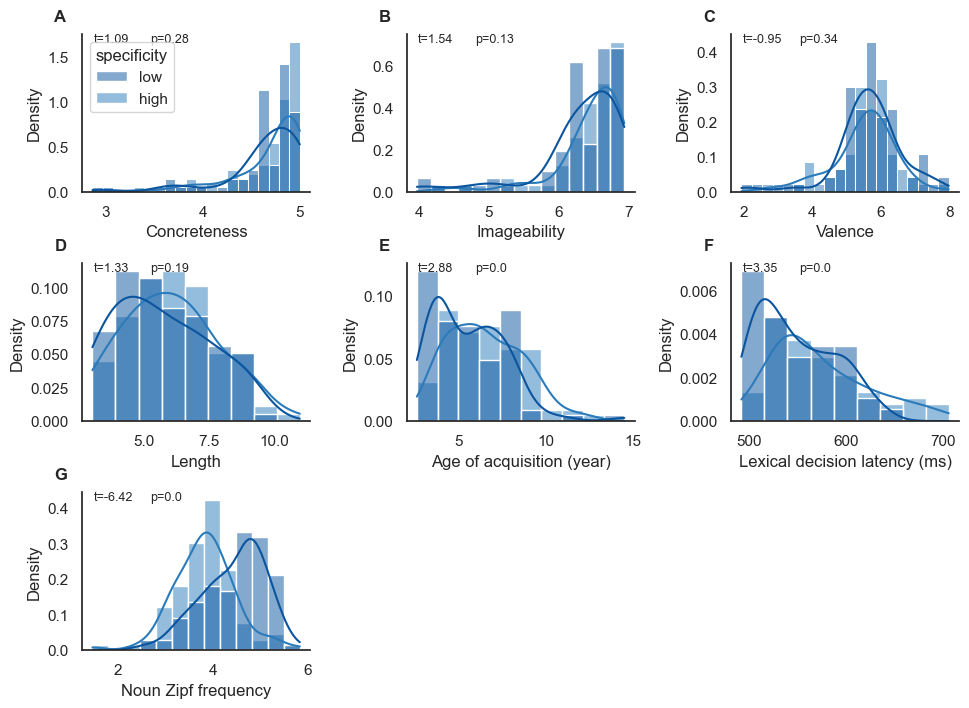

In [26]:
data = stimuli.query('specificity=="high" | specificity=="low"')

fig, axes = plt.subplots(3, 3, figsize=(10,7))
sns.set_context(font_scale=1)
sns.set_theme(style='white', palette='Blues_r')

sns.histplot(x='CNC_M', hue='specificity', data=data, ax=axes[0,0], stat='density', kde=True).set_xlabel('Concreteness')
sns.histplot(x='imageability', hue='specificity', data=data, ax=axes[0,1], stat='density', kde=True).set_xlabel('Imageability')
sns.histplot(x='valence', hue='specificity', data=data, ax=axes[0,2], stat='density', kde=True).set_xlabel('Valence')

sns.histplot(x='length', hue='specificity', data=data, ax=axes[1,0], stat='density', kde=True).set_xlabel('Length')
sns.histplot(x='AoA', hue='specificity', data=data, ax=axes[1,1], stat='density', kde=True).set_xlabel('Age of acquisition (year)')
sns.histplot(x='RT', hue='specificity', data=data, ax=axes[1,2], stat='density', kde=True).set_xlabel('Lexical decision latency (ms)')

sns.histplot(x='zipf', hue='specificity', data=data, ax=axes[2,0], stat='density', kde=True).set_xlabel('Noun Zipf frequency')

fig.tight_layout()
sns.despine()

# remove legend for some subplots
for ax in axes.ravel()[1:-1]:
    ax.legend([],[], frameon=False)
    
# add statistics comparing high and low specificity nouns 
for ax, feature in zip(axes.ravel(),['CNC_M','imageability','valence','length','AoA','RT','zipf']):
    t_stats = compute_stats(feature)
    ax.annotate(f't={round(t_stats[0],2)}', xy=(0.05, 0.95), xycoords='axes fraction', transform=ax.transAxes, fontsize=9)
    ax.annotate(f'p={round(t_stats[1],2)}', xy=(0.3, 0.95), xycoords='axes fraction', transform=ax.transAxes, fontsize=9)
    
import matplotlib.transforms as mtransforms
for ax, label in zip(axes.ravel(), 'ABCDEFGHIJ'):
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='medium', va='bottom', fontweight='bold')

fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])